<h1><center>Проект Токсичные комментарии</center></h1>

# Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.


Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.


Постройте модель со значением метрики качества F1 не меньше 0.75.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Импорт-модулей" data-toc-modified-id="Импорт-модулей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорт модулей</a></span></li><li><span><a href="#Константы" data-toc-modified-id="Константы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Константы</a></span></li><li><span><a href="#Функции" data-toc-modified-id="Функции-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Функции</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Описание данных

Данные находятся в файле /datasets/toxic_comments.csv

Столбец text в нём содержит текст комментария, а toxic — целевой признак.

## Импорт модулей

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import time

import re 

from textblob import TextBlob, Word
from pymystem3 import Mystem

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV


nltk.download('wordnet')
nltk.download('stopwords')

ModuleNotFoundError: No module named 'textblob'

## Константы

In [2]:
RANDOM_STATE = 12345

## Функции

In [3]:
# Общая информация о датасете -----------------------------------------

def info_head(df, rows=5):
    
    df.info()
    
    display(df.head(rows))

    
# Определение части речи -----------------------------------------

def get_wordnet_pos(word):
    
    tag = nltk.pos_tag([word])[0][1][0].upper()
    
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    return tag_dict.get(tag, wordnet.NOUN)


# Лемматизация с определенными частями речи -----------------------------------------

def lemma_pos(row):
    
    nltk_lemmatizer = WordNetLemmatizer()
    
    word_list = nltk.word_tokenize(row)
    
    row = ' '.join([nltk_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
       
    return row
  
    
# Удаление лишних символов -----------------------------------------   
    
def regular_expressions(row):

    row = ' '.join(re.sub(r'[^a-zA-Z]', ' ', row).split())
    
    return row


# Лемматизация с удалением лишних символов ----------------------------------

def lemma_pos_re(row):
    
    lemma = nltk_lemma_pos(row)
    
    return regular_expressions(lemma)


# Удаление стоп-слов ----------------------------------

def remove_stop_words(row):
    
    stop_words = set(stopwords.words('english')) 
    
    word_list = nltk.word_tokenize(row)
    
    row =  " ". join([word for word in word_list if not word in stop_words])  
    
    return row


# Лингвистическая обработка одного текста ----------------------------------

def processing_row(row):
    
    nltk_lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english')) 
    
    word_list_edit = []
    word_list = nltk.word_tokenize(row)

    for word in word_list:

        word = nltk_lemmatizer.lemmatize(word, get_wordnet_pos(word))
        word = re.sub(r'[^a-zA-Z]', ' ', word)
        word = word.lower()

        if not word in stop_words:
            word_list_edit.append(word)

    row = " ".join([word for word in word_list_edit])
    
    row = " ".join(row.split())

    return row


# Полная обработка датасета перед обучением ----------------------------------

def processing(df):
    
    df = df.drop_duplicates()
    
    df['text'] = df['text'].apply(processing_row)
            
    df = df.dropna()    
    
    return df['text'], df['toxic']

## Загрузка данных

In [2]:
comments = pd.read_csv('datasets/toxic_comments.csv')

NameError: name 'pd' is not defined

In [5]:
info_head(comments)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


- Исходный датасет представляет из себя набор комментариев (скорее всего только на английском языке) и соответсвующие им категории - "токсичные - 1" и не "токсичные - 0" 


- Пропусков не обнаружено

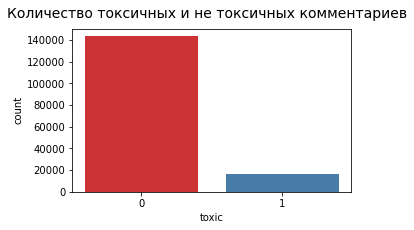

Количество нетоксичных комментариев составляет 89.8%

Количество токсичных комментариев составляет 10.2%


In [6]:
fig, ax = plt.subplots(figsize=(5,3))

fig.suptitle('Количество токсичных и не токсичных комментариев', fontsize=14)

ax.set(xlabel='Количество', ylabel='Токсичнось')

sns.countplot(x=comments['toxic'], ax=ax, palette="Set1")

plt.plot()
plt.show()

count_comments = comments.pivot_table(columns='toxic', aggfunc='count')

count_total = count_comments.values[0][0] + count_comments.values[0][1]

count_toxic = count_comments.values[0][1]/count_total

count_non_toxic = count_comments.values[0][0] / count_total


print('Количество нетоксичных комментариев составляет {:1.1%}\n'.format(count_non_toxic))
print('Количество токсичных комментариев составляет {:1.1%}'.format(count_toxic))

- В датасете преобладают нетоксичные комментарии (~90%), это стоит учесть при обучении модели

## Подготовка данных

- Разделим данные на выборки для тестирования (25%) и обучения (75%)

In [7]:
train, test = train_test_split(comments, test_size=0.25, random_state=RANDOM_STATE)

In [8]:
print('Размер обучающей выборки:', train.shape[0])
print('Размер тестовой выборки:', test.shape[0])

Размер обучающей выборки: 119678
Размер тестовой выборки: 39893


- Далее будем работать с выборкой для обучения

- Проверим наличие дубликатов

In [9]:
count_duplicates = train.shape[0] - train.drop_duplicates().shape[0]

print('Количество дубликатов равно', count_duplicates)

Количество дубликатов равно 0


- Дубликатов не обнаружено

- Проведем лемматизацию текста

In [10]:
pd.options.mode.chained_assignment = None  # default='warn'

start = time.time()

train['text_lemma']=train['text'].apply(lemma_pos)

end = time.time()

time_lemma_pos = end - start

print('Время лемматизации составляет {:.2f} сек'.format(time_lemma_pos))

display(train.head(5))

- Удалим лишние символы

In [12]:
pd.options.mode.chained_assignment = None  # default='warn'

start = time.time()

train['text_lemma_re']=train['text_lemma'].apply(regular_expressions)

end = time.time()

time_re = end - start

print('Время удаления лишних символов составляет {:.2f} сек'.format(time_re))

display(train.head(5))

Время удаления лишних символов составляет 3.05 сек


,Unnamed: 0,text,toxic,text_lemma,text_lemma_re
0,111565,"""\n\nAth Cliath section\nWe have a bit of a pr...",0,`` Ath Cliath section We have a bit of a probl...,Ath Cliath section We have a bit of a problem ...
1,8575,"""\nSure thing. By the way, I have a new userb...",0,"`` Sure thing . By the way , I have a new user...",Sure thing By the way I have a new userbox tha...
2,153402,""":::We are in the same boat as Britannica (whi...",0,`` : : : We be in the same boat a Britannica (...,We be in the same boat a Britannica which be a...
3,65019,"""I had a look through the section on theology ...",0,`` I have a look through the section on theolo...,I have a look through the section on theology ...
4,155787,"""\n\n Warren Commission Exhibit 746-E the """"C...",0,`` Warren Commission Exhibit 746-E the `` '' C...,Warren Commission Exhibit E the Chin It be tim...


- Для стандартизации проведем все буквы к строчному виду

In [13]:
start = time.time()

train['text_lemma_re'] = train['text_lemma_re'].str.lower()

end = time.time()

time_lowercase = end - start

print('Время приведения к строчному виду составляет {:.2f} сек'.format(time_lowercase))

display(train.head(5))

Время приведения к строчному виду составляет 0.11 сек


,Unnamed: 0,text,toxic,text_lemma,text_lemma_re
0,111565,"""\n\nAth Cliath section\nWe have a bit of a pr...",0,`` Ath Cliath section We have a bit of a probl...,ath cliath section we have a bit of a problem ...
1,8575,"""\nSure thing. By the way, I have a new userb...",0,"`` Sure thing . By the way , I have a new user...",sure thing by the way i have a new userbox tha...
2,153402,""":::We are in the same boat as Britannica (whi...",0,`` : : : We be in the same boat a Britannica (...,we be in the same boat a britannica which be a...
3,65019,"""I had a look through the section on theology ...",0,`` I have a look through the section on theolo...,i have a look through the section on theology ...
4,155787,"""\n\n Warren Commission Exhibit 746-E the """"C...",0,`` Warren Commission Exhibit 746-E the `` '' C...,warren commission exhibit e the chin it be tim...


- Удалим стоп слова

In [14]:
start = time.time()

train['text_lemma_re_stopwords'] = train['text_lemma_re'].dropna().apply(remove_stop_words)

end = time.time()

time_stopwords = end - start

print('Время удаления стоп-слов составляет {:.2f} сек'.format(time_stopwords))

display(train.head(5))

Время удаления стоп-слов составляет 50.36 сек


,Unnamed: 0,text,toxic,text_lemma,text_lemma_re,text_lemma_re_stopwords
0,111565,"""\n\nAth Cliath section\nWe have a bit of a pr...",0,`` Ath Cliath section We have a bit of a probl...,ath cliath section we have a bit of a problem ...,ath cliath section bit problem irish name bail...
1,8575,"""\nSure thing. By the way, I have a new userb...",0,"`` Sure thing . By the way , I have a new user...",sure thing by the way i have a new userbox tha...,sure thing way new userbox say user support sa...
2,153402,""":::We are in the same boat as Britannica (whi...",0,`` : : : We be in the same boat a Britannica (...,we be in the same boat a britannica which be a...,boat britannica actually publish states britan...
3,65019,"""I had a look through the section on theology ...",0,`` I have a look through the section on theolo...,i have a look through the section on theology ...,look section theology come across original sin...
4,155787,"""\n\n Warren Commission Exhibit 746-E the """"C...",0,`` Warren Commission Exhibit 746-E the `` '' C...,warren commission exhibit e the chin it be tim...,warren commission exhibit e chin time confront...


- Удалим образовавшиеся пустые строки

In [15]:
train.dropna(inplace=True)

- Обработка обучающего датасета завершена

In [16]:
info_head(train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119678 entries, 0 to 119677
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Unnamed: 0               119678 non-null  int64 
 1   text                     119678 non-null  object
 2   toxic                    119678 non-null  int64 
 3   text_lemma               119678 non-null  object
 4   text_lemma_re            119678 non-null  object
 5   text_lemma_re_stopwords  119678 non-null  object
dtypes: int64(2), object(4)
memory usage: 6.4+ MB


,Unnamed: 0,text,toxic,text_lemma,text_lemma_re,text_lemma_re_stopwords
0,111565,"""\n\nAth Cliath section\nWe have a bit of a pr...",0,`` Ath Cliath section We have a bit of a probl...,ath cliath section we have a bit of a problem ...,ath cliath section bit problem irish name bail...
1,8575,"""\nSure thing. By the way, I have a new userb...",0,"`` Sure thing . By the way , I have a new user...",sure thing by the way i have a new userbox tha...,sure thing way new userbox say user support sa...
2,153402,""":::We are in the same boat as Britannica (whi...",0,`` : : : We be in the same boat a Britannica (...,we be in the same boat a britannica which be a...,boat britannica actually publish states britan...
3,65019,"""I had a look through the section on theology ...",0,`` I have a look through the section on theolo...,i have a look through the section on theology ...,look section theology come across original sin...
4,155787,"""\n\n Warren Commission Exhibit 746-E the """"C...",0,`` Warren Commission Exhibit 746-E the `` '' C...,warren commission exhibit e the chin it be tim...,warren commission exhibit e chin time confront...


- Общая обработка датасета перед обучением состояла из следующих шагов:

        1. Удаление дубликатов

        2. Лемматизация

        3. Удаление лишних символов

        4. Приведение к строчному виду

        5. Удаление стоп-слов

        6. Удаление пустых строк

## Обучение

- Разделим признаки обучающей выборки

In [17]:
X_train = train['text_lemma_re_stopwords']
y_train = train['toxic']

- Построим вектор слов

In [18]:
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)

- Рассчитаем TF-IDF 

In [19]:
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

- Обучим модель логической регрессии


- В параметрах моделей для обучения укажем балансировку классов

In [21]:
scorer = make_scorer(f1_score, greater_is_better=True)

In [22]:
lg = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='lbfgs')

In [23]:
param_grid = {
    'max_iter' : [500, 1000, 1500],
    'C': [1, 10, 20],
}

In [24]:
lg_grid_search = GridSearchCV(lg, param_grid, cv=9, scoring=scorer)

In [25]:
%%time
lg_grid_search.fit(X_train_tfidf, y_train)

Wall time: 9min 37s


GridSearchCV(cv=9,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=12345),
             param_grid={'C': [1, 10, 20], 'max_iter': [500, 1000, 1500]},
             scoring=make_scorer(f1_score))

In [45]:
lg_params = lg_grid_search.best_params_

f1_lg = lg_grid_search.best_score_

display(lg_params)

{'C': 10, 'max_iter': 500}

In [46]:
lg = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='lbfgs', C=10, max_iter=500)

lg.fit(X_train_tfidf, y_train)

LogisticRegression(C=10, class_weight='balanced', max_iter=500,
                   random_state=12345)

- Обучим модель логической регрессии с кросс-валидацией


- В данной модели встроен алгоритм стратифицированной кросс-валидации, позовляющий сохранять пропорции классов для каждой подвыборки, при этом балансировку классов весами отключим

In [33]:
%%time

lg_cv = LogisticRegressionCV(cv=9, scoring=scorer, random_state=RANDOM_STATE, max_iter=2000, solver='lbfgs')

lg_cv.fit(X_train_tfidf, y_train)

Wall time: 14min 11s


LogisticRegressionCV(cv=9, max_iter=2000, random_state=12345,
                     scoring=make_scorer(f1_score))

In [50]:
f1_lg_cv = lg_cv.scores_[1].mean(axis=0).max()

- Дополнительно обучим модель опорных векторов - SVC

In [28]:
svc = LinearSVC(random_state=RANDOM_STATE, class_weight='balanced', max_iter=5000, penalty='l2')

In [29]:
param_grid = {
    'C': [1, 10, 20],
}

In [30]:
svc_grid_search = GridSearchCV(svc, param_grid, cv=9, scoring=scorer)

In [31]:
%%time
svc_grid_search.fit(X_train_tfidf, y_train)

Wall time: 6min 4s


GridSearchCV(cv=9,
             estimator=LinearSVC(class_weight='balanced', max_iter=5000,
                                 random_state=12345),
             param_grid={'C': [1, 10, 20]}, scoring=make_scorer(f1_score))

In [47]:
svc_params = svc_grid_search.best_params_

f1_svc = svc_grid_search.best_score_

display(svc_params)

{'C': 1}

In [48]:
svc = LinearSVC(random_state=RANDOM_STATE, class_weight='balanced', max_iter=5000, penalty='l2', C=1)

svc.fit(X_train_tfidf, y_train)

LinearSVC(C=1, class_weight='balanced', max_iter=5000, random_state=12345)

- Составим сводную таблицу результатов обучения

In [51]:
train_results = pd.DataFrame(   
                                data = [f1_lg, f1_lg_cv, f1_svc], 
                                columns = ['Метрика f1'], 
                                index=['Логическая регрессия', 'Логическая регрессия с кросс-валидацией', 'Метод опорных векторов']
                           )

display(train_results.sort_values(by='Метрика f1', ascending=False).round(2))

,Метрика f1
Логическая регрессия с кросс-валидацией,0.76
Логическая регрессия,0.76
Метод опорных векторов,0.75


## Тестирование

- Проведем тестирование модели

- Подготовим и разделим тестовую выборку на признаки

In [69]:
%%time
X_test, y_test = processing(test)

Wall time: 22min 22s


- Для тестовых признаков создадим вектор слов и рассчитаем TF-IDF

In [70]:
X_test_counts = count_vect.transform(X_test)

X_test_tfidf = tfidf_transformer.transform(X_test_counts)

- Получим предсказания для тестовой выборки на разных моделях

In [71]:
y_test_pred_lg = lg.predict(X_test_tfidf)

y_test_pred_lg_cv = lg_cv.predict(X_test_tfidf)

y_test_pred_svc = svc.predict(X_test_tfidf)

- Определим значения метрики f1

In [72]:
test_results_lg = f1_score(y_test, y_test_pred_lg)

test_results_lg_cv = f1_score(y_test, y_test_pred_lg_cv)

test_results_svc = f1_score(y_test, y_test_pred_svc)

- Составим сводную таблицу результатов тестирования

In [73]:
test_results = pd.DataFrame(    
                                data = [test_results_lg, test_results_lg_cv, test_results_svc], 
                                columns = ['Метрика f1'], 
                                index=['Логическая регрессия', 'Логическая регрессия с кросс-валидацией', 'Метод опорных векторов']
                           )

display(test_results.sort_values(by='Метрика f1', ascending=False).round(2))

,Метрика f1
Логическая регрессия с кросс-валидацией,0.78
Логическая регрессия,0.76
Метод опорных векторов,0.76


- Модели логической регрессии показали удовлетворительное значение метрики f1 (>0.75)


- Модель логической регрессии с кросс-валидацией показала наилушчий результат

## Общий вывод

- Текстовые данные были обработаны по следующему алгоритму

        1. Удаление дубликатов

        2. Лемматизация

        3. Удаление лишних символов

        4. Приведение к строчному виду

        5. Удаление стоп-слов

        6. Удаление пустых строк
        
        
- В данных наблюдается сильной дисбаланс классов (10% комментариев - "токсичные", остальные 90% - нет). Для учета дисбаланса в моделях была применена балансировка весами и опробована стратифицированная кросс-валидация


- Были обучены три типа моделей: 

        1. Логическая регрессия с балансировкой классов весами
        
        2. Логическая регрессия с кросс-валидацией
        
        3. Метод опорных векторов
        
        
- Модели логической регрессии показали удовлетворительное значение метрики f1 (>0.75)


- Наилучший результат на тестовых данных показала модель логическая регрессии с кросс-валидацией 